# Guia do Projeto - Tech Challenge Fase 4 - Parte 06

## Pipeline Final: Módulo de Análise de Vídeo

Este notebook representa a consolidação de todo o trabalho desenvolvido. Aqui, apresentamos o **Módulo de Análise de Vídeo** completo, capaz de receber um arquivo de vídeo bruto e gerar um relatório detalhado sobre as cenas, pessoas, emoções e atividades detectadas.

### O Que Este Módulo Faz?

1.  **Recebe um Vídeo**: Qualquer arquivo MP4, AVI, etc.
2.  **Detecta Cenas**: Segmenta o vídeo em partes lógicas.
3.  **Analisa Conteúdo**: Para cada cena, detecta rostos, emoções e atividades.
4.  **Gera Relatório**: Cria uma tabela resumo e uma galeria visual das cenas.

### Independência do Código
Para garantir que este notebook funcione de forma independente (standalone), todo o código necessário (classes e funções desenvolvidas nos notebooks 01 a 05) está incluído na primeira célula de código abaixo.

In [1]:
import cv2
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from dataclasses import dataclass, field
from typing import List, Optional, Tuple, Dict, Deque, Any, Generator
from collections import deque, Counter
from ultralytics import YOLO
from deepface import DeepFace
from datetime import timedelta
import logging

# Suprimir logs excessivos
os.environ["YOLO_VERBOSE"] = "False"
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# ==========================================
# 1. MODELOS DE DADOS (Data Classes)
# ==========================================

@dataclass
class BoundingBox:
    x: int; y: int; width: int; height: int

@dataclass
class FaceDetection:
    bounding_box: BoundingBox; confidence: float

@dataclass
class EmotionAnalysis:
    emotion: str; confidence: float

@dataclass
class ActivityDetection:
    activity: str; confidence: float; track_id: Optional[int] = None

@dataclass
class Scene:
    scene_id: int
    start_frame: int
    end_frame: int
    start_time: float
    end_time: float
    @property
    def duration_seconds(self) -> float: return self.end_time - self.start_time

@dataclass
class SceneResult:
    scene: Scene
    unique_faces: int = 0
    dominant_emotions: Dict[str, int] = field(default_factory=dict)
    dominant_actions: Dict[str, int] = field(default_factory=dict)

# ==========================================
# 2. DETECTORES E ANALISADORES (Core Logic)
# ==========================================

class FaceDetector:
    def __init__(self, model_path: str = "yolo11n-pose.pt", confidence_threshold: float = 0.5):
        self.model = YOLO(model_path)
        self.confidence_threshold = confidence_threshold

    def detect(self, frame) -> List[FaceDetection]:
        results = self.model(frame, conf=self.confidence_threshold, verbose=False)
        faces = []
        frame_height, frame_width = frame.shape[:2]

        for result in results:
            if result.keypoints is None: continue
            keypoints = result.keypoints.data
            for person_keypoints in keypoints:
                # Simplificação: Usar keypoints do rosto (nariz, olhos) para estimar a caixa
                face_kps = person_keypoints[:3]
                if face_kps[0][2] > 0.5: # Se nariz visível
                    x_min = int(face_kps[:, 0].min())
                    y_min = int(face_kps[:, 1].min())
                    x_max = int(face_kps[:, 0].max())
                    y_max = int(face_kps[:, 1].max())
                    w = x_max - x_min
                    h = y_max - y_min
                    pad = int(w * 0.5)
                    
                    faces.append(FaceDetection(
                        bounding_box=BoundingBox(
                            x=max(0, x_min - pad), 
                            y=max(0, y_min - pad), 
                            width=w + 2*pad, 
                            height=h + 2*pad
                        ),
                        confidence=0.9
                    ))
        return faces

class EmotionAnalyzer:
    def analyze(self, frame: np.ndarray, faces: List[FaceDetection]) -> List[EmotionAnalysis]:
        emotions = []
        for face in faces:
            bbox = face.bounding_box
            x, y = max(0, bbox.x), max(0, bbox.y)
            x_end, y_end = min(frame.shape[1], x + bbox.width), min(frame.shape[0], y + bbox.height)
            face_img = frame[y:y_end, x:x_end]
            
            if face_img.size == 0:
                emotions.append(EmotionAnalysis("unknown", 0.0))
                continue

            try:
                result = DeepFace.analyze(face_img, actions=['emotion'], enforce_detection=False, detector_backend='skip', silent=True)
                if isinstance(result, list): result = result[0]
                dom = result['dominant_emotion']
                conf = result['emotion'][dom] / 100.0
                emotions.append(EmotionAnalysis(dom, conf))
            except:
                emotions.append(EmotionAnalysis("unknown", 0.0))
        return emotions

class ActivityDetector:
    def __init__(self, model_path: str = "yolo11n-pose.pt"):
        self.model = YOLO(model_path)
        self.track_history = {}

    def detect(self, frame: np.ndarray) -> List[ActivityDetection]:
        results = self.model.track(frame, persist=True, verbose=False, tracker="bytetrack.yaml")
        activities = []
        
        for result in results:
            if result.boxes is None or result.keypoints is None: continue
            boxes = result.boxes
            keypoints = result.keypoints.data
            
            for i, kps in enumerate(keypoints):
                track_id = int(boxes.id[i].item()) if boxes.id is not None else -1
                
                # Lógica Heurística Simplificada
                nose = kps[0]
                l_wrist, r_wrist = kps[9], kps[10]
                l_shoulder, r_shoulder = kps[5], kps[6]
                
                activity = "standing"
                if (l_wrist[2]>0.5 and l_shoulder[2]>0.5 and l_wrist[1] < l_shoulder[1]) or \
                   (r_wrist[2]>0.5 and r_shoulder[2]>0.5 and r_wrist[1] < r_shoulder[1]):
                    activity = "waving"
                elif nose[2]>0.5 and ((l_wrist[2]>0.5 and np.linalg.norm(l_wrist[:2]-nose[:2])<50) or \
                                      (r_wrist[2]>0.5 and np.linalg.norm(r_wrist[:2]-nose[:2])<50)):
                    activity = "talking"
                
                activities.append(ActivityDetection(activity, 0.8, track_id))
        return activities

class SceneDetector:
    def __init__(self, threshold=0.5):
        self.threshold = threshold
    
    def detect_scenes(self, video_path: str) -> List[Scene]:
        cap = cv2.VideoCapture(video_path)
        fps = cap.get(cv2.CAP_PROP_FPS)
        scenes = []
        scene_start = 0
        scene_id = 1
        
        ret, prev = cap.read()
        if not ret: return []
        prev_hist = cv2.calcHist([prev], [0], None, [256], [0, 256])
        cv2.normalize(prev_hist, prev_hist, 0, 1, cv2.NORM_MINMAX)
        
        frame_num = 1
        while True:
            ret, curr = cap.read()
            if not ret: break
            curr_hist = cv2.calcHist([curr], [0], None, [256], [0, 256])
            cv2.normalize(curr_hist, curr_hist, 0, 1, cv2.NORM_MINMAX)
            score = cv2.compareHist(prev_hist, curr_hist, cv2.HISTCMP_CORREL)
            
            if score < self.threshold:
                scenes.append(Scene(scene_id, scene_start, frame_num-1, scene_start/fps, (frame_num-1)/fps))
                scene_id += 1
                scene_start = frame_num
            prev_hist = curr_hist
            frame_num += 1
            
        scenes.append(Scene(scene_id, scene_start, frame_num-1, scene_start/fps, (frame_num-1)/fps))
        cap.release()
        return scenes

# ==========================================
# 3. ORQUESTRADOR (Pipeline Principal)
# ==========================================

class VideoSceneAnalyzer:
    def __init__(self, video_path, scene_threshold=0.5, sample_rate=5):
        self.video_path = video_path
        self.sample_rate = sample_rate
        self.scene_detector = SceneDetector(scene_threshold)
        self.face_detector = FaceDetector()
        self.emotion_analyzer = EmotionAnalyzer()
        self.activity_detector = ActivityDetector()
        
    def analyze(self) -> List[SceneResult]:
        print("1. Detectando cenas...")
        scenes = self.scene_detector.detect_scenes(self.video_path)
        print(f"   -> {len(scenes)} cenas encontradas.")
        
        results = []
        cap = cv2.VideoCapture(self.video_path)
        
        for scene in scenes:
            print(f"2. Analisando Cena {scene.scene_id}...")
            cap.set(cv2.CAP_PROP_POS_FRAMES, scene.start_frame)
            emotions_cnt = Counter()
            actions_cnt = Counter()
            unique_faces = set()
            
            curr = scene.start_frame
            while curr <= scene.end_frame:
                ret, frame = cap.read()
                if not ret: break
                
                if (curr - scene.start_frame) % self.sample_rate == 0:
                    # Atividades
                    acts = self.activity_detector.detect(frame)
                    for a in acts:
                        actions_cnt[a.activity] += 1
                        if a.track_id: unique_faces.add(a.track_id)
                    
                    # Emoções
                    faces = self.face_detector.detect(frame)
                    ems = self.emotion_analyzer.analyze(frame, faces)
                    for e in ems: emotions_cnt[e.emotion] += 1
                
                curr += 1
            
            results.append(SceneResult(
                scene, 
                len(unique_faces), 
                dict(emotions_cnt.most_common(3)), 
                dict(actions_cnt.most_common(3))
            ))
        cap.release()
        return results

### 4. Execução do Pipeline

Agora, vamos rodar o sistema completo no nosso vídeo de exemplo.

In [2]:
video_path = "meu_video.mp4"

if os.path.exists(video_path):
    analyzer = VideoSceneAnalyzer(video_path, scene_threshold=0.6, sample_rate=10)
    results = analyzer.analyze()
else:
    print(f"Vídeo {video_path} não encontrado. Certifique-se de fazer o upload.")
    results = []

1. Detectando cenas...
   -> 18 cenas encontradas.
2. Analisando Cena 1...
2. Analisando Cena 2...
2. Analisando Cena 3...
2. Analisando Cena 4...
2. Analisando Cena 5...
2. Analisando Cena 6...
2. Analisando Cena 7...
2. Analisando Cena 8...
2. Analisando Cena 9...
2. Analisando Cena 10...
2. Analisando Cena 11...
2. Analisando Cena 12...
2. Analisando Cena 13...
2. Analisando Cena 14...
2. Analisando Cena 15...
2. Analisando Cena 16...
2. Analisando Cena 17...
2. Analisando Cena 18...


### 5. Relatório Final

Apresentamos os resultados em formato tabular e visual.

In [3]:
if results:
    report_data = []
    for res in results:
        scene = res.scene
        emotions_str = ", ".join([f"{k}({v})" for k, v in res.dominant_emotions.items()])
        actions_str = ", ".join([f"{k}({v})" for k, v in res.dominant_actions.items()])
        
        report_data.append({
            "Cena": scene.scene_id,
            "Início": str(timedelta(seconds=int(scene.start_time))),
            "Fim": str(timedelta(seconds=int(scene.end_time))),
            "Duração": f"{scene.duration_seconds:.1f}s",
            "Pessoas": res.unique_faces,
            "Emoções": emotions_str,
            "Ações": actions_str
        })

    df = pd.DataFrame(report_data)
    print("=== RELATÓRIO DE ANÁLISE DE VÍDEO ===")
    display(df)
    
    # Salvar CSV
    df.to_csv("relatorio_final.csv", index=False)
    print("Relatório salvo como 'relatorio_final.csv'")

=== RELATÓRIO DE ANÁLISE DE VÍDEO ===


Cena   Início      Fim Duração  Pessoas                           Emoções  \
0      1  0:00:00  0:00:05    6.0s        4       sad(35), fear(12), happy(9)   
1      2  0:00:06  0:00:11    6.0s        1         sad(7), fear(6), happy(2)   
2      3  0:00:12  0:00:17    6.0s        0                                     
3      4  0:00:18  0:00:23    6.0s        1      sad(6), neutral(3), happy(3)   
4      5  0:00:24  0:00:29    6.0s        1                         happy(18)   
5      6  0:00:30  0:00:35    6.0s        1                          fear(18)   
6      7  0:00:36  0:00:41    6.0s        1                happy(16), fear(2)   
7      8  0:00:42  0:00:47    6.0s        1       fear(7), sad(4), neutral(4)   
8      9  0:00:48  0:00:53    6.0s        1         sad(7), fear(6), happy(4)   
9     10  0:00:54  0:00:56    3.0s        1               neutral(6), fear(3)   
10    11  0:00:57  0:01:00    4.0s        1  fear(9), neutral(2), surprise(1)   
11    12  0:01:01  0:01:06    6.0s        2        fear(12), sad(3), happy(2)   
12    13  0:01:07  0:01:18   12.0s        4    neutral(28), fear(20), sad(11)   
13    14  0:01:19  0:01:19    1.0s        1                 angry(2), fear(1)   
14    15  0:01:20  0:01:31   12.0s        6    sad(39), fear(33), neutral(24)   
15    16  0:01:32  0:01:37    6.0s        2               neutral(6), fear(4)   
16    17  0:01:38  0:01:49   12.0s       10    fear(23), sad(22), neutral(17)   
17    18  0:01:50  0:01:50    0.8s        1                   fear(2), sad(1)   

                                   Ações  
0                           standing(72)  
1                standing(15), waving(3)  
2                                         
3                waving(12), standing(6)  
4                           standing(18)  
5                standing(14), waving(4)  
6                             waving(18)  
7                           standing(18)  
8                           standing(18)  
9                            standing(9)  
10                          standing(12)  
11               standing(28), waving(4)  
12   standing(66), talking(1), waving(1)  
13                           standing(3)  
14  standing(86), waving(32), talking(5)  
15                          standing(20)  
16                         standing(134)  
17                           standing(3)

Relatório salvo como 'relatorio_final.csv'


### 6. Galeria Visual das Cenas

Para facilitar a validação, mostramos um frame representativo de cada cena.

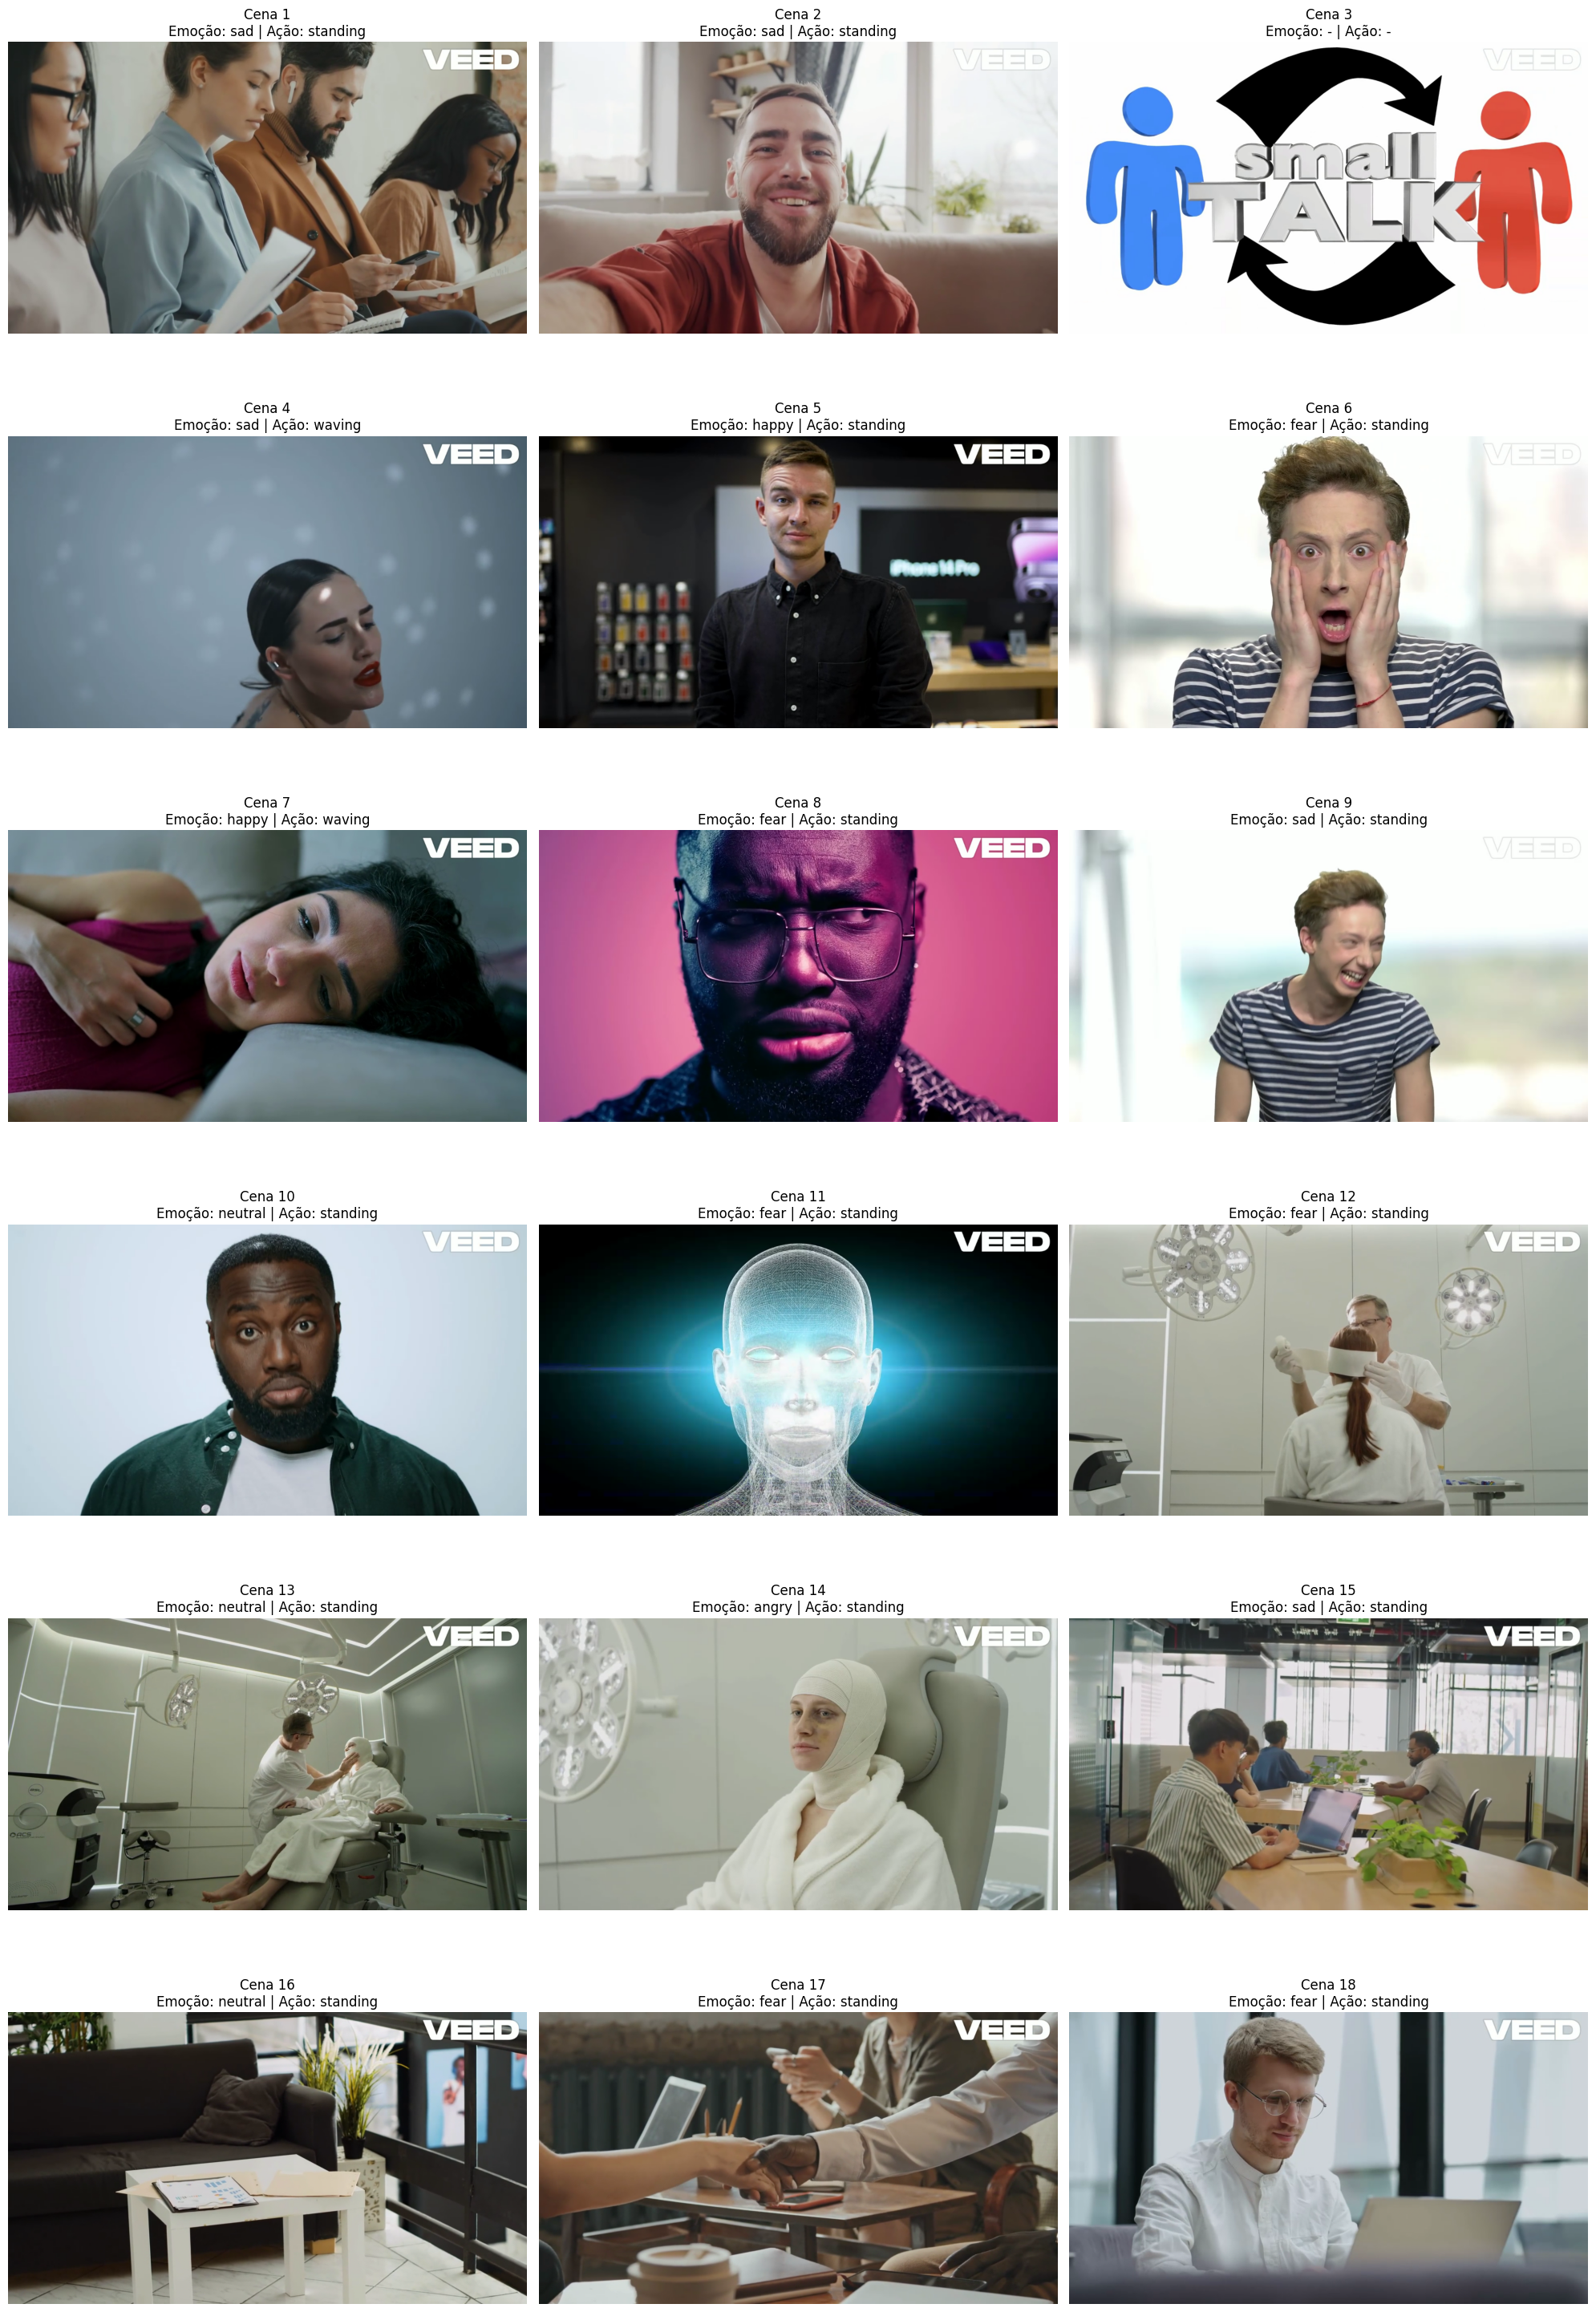

In [4]:
def visualize_scenes(video_path, results):
    if not results: return
    
    num_scenes = len(results)
    cols = 3
    rows = math.ceil(num_scenes / cols)
    
    plt.figure(figsize=(20, 5 * rows))
    cap = cv2.VideoCapture(video_path)
    
    for i, res in enumerate(results):
        scene = res.scene
        mid_frame = (scene.start_frame + scene.end_frame) // 2
        cap.set(cv2.CAP_PROP_POS_FRAMES, mid_frame)
        ret, frame = cap.read()
        
        if ret:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            top_emotion = list(res.dominant_emotions.keys())[0] if res.dominant_emotions else "-"
            top_action = list(res.dominant_actions.keys())[0] if res.dominant_actions else "-"
            
            plt.subplot(rows, cols, i + 1)
            plt.imshow(frame_rgb)
            plt.title(f"Cena {scene.scene_id}\nEmoção: {top_emotion} | Ação: {top_action}")
            plt.axis('off')
            
    cap.release()
    plt.tight_layout()
    plt.show()

if results:
    visualize_scenes(video_path, results)

## Conclusão

Neste notebook, integramos com sucesso:
1.  **Detecção de Cenas**: Segmentação temporal do vídeo.
2.  **Detecção Facial e Emoções**: Análise detalhada das expressões.
3.  **Reconhecimento de Atividades**: Identificação de ações corporais.
4.  **Geração de Relatório**: Consolidação dos dados em formato acionável.

Este módulo serve como o "cérebro" do nosso sistema. O próximo passo lógico é encapsular esta lógica em uma **API (Microserviço)** para que possa ser consumida por uma interface web (Frontend), permitindo que usuários façam upload de vídeos e visualizem os resultados de forma interativa.